#![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png) + ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
#Power Plant Machine Learning Pipeline Application
This notebook is an end-to-end exercise of performing Extract-Transform-Load and Exploratory Data Analysis on a real-world dataset, and then applying several different machine learning algorithms to solve a supervised regression problem on the dataset.

** This notebook covers: **
* *Part 1: Business Understanding*
* *Part 2: Load Your Data*
* *Part 3: Explore Your Data*
* *Part 4: Visualize Your Data*
* *Part 5: Data Preparation*
* *Part 6: Data Modeling*
* *Part 7: Tuning and Evaluation*

*Our goal is to accurately predict power output given a set of environmental readings from various sensors in a natural gas-fired power generation plant.*

** Background **

Power generation is a complex process, and understanding and predicting power output is an important element in managing a plant and its connection to the power grid. The operators of a regional power grid create predictions of power demand based on historical information and environmental factors (e.g., temperature). They then compare the predictions against available resources (e.g., coal, natural gas, nuclear, solar, wind, hydro power plants). Power generation technologies such as solar and wind are highly dependent on environmental conditions, and all generation technologies are subject to planned and unplanned maintenance.

Here is an real-world example of predicted demand (on two time scales), actual demand, and available resources from the California power grid: http://www.caiso.com/Pages/TodaysOutlook.aspx


The challenge for a power grid operator is how to handle a shortfall in available resources versus actual demand. There are three solutions to  a power shortfall: build more base load power plants (this process can take many years to decades of planning and construction), buy and import power from other regional power grids (this choice can be very expensive and is limited by the power transmission interconnects between grids and the excess power available from other grids), or turn on small [Peaker or Peaking Power Plants](https://en.wikipedia.org/wiki/Peaking_power_plant). Because grid operators need to respond quickly to a power shortfall to avoid a power outage, grid operators rely on a combination of the last two choices. In this exercise, we'll focus on the last choice.

** The Business Problem **

Because they supply power only occasionally, the power supplied by a peaker power plant commands a much higher price per kilowatt hour than power from a power grid's base power plants. A peaker plant may operate many hours a day, or it may operate only a few hours per year, depending on the condition of the region's electrical grid. Because of the cost of building an efficient power plant, if a peaker plant is only going to be run for a short or highly variable time it does not make economic sense to make it as efficient as a base load power plant. In addition, the equipment and fuels used in base load plants are often unsuitable for use in peaker plants because the fluctuating conditions would severely strain the equipment.

The power output of a peaker power plant varies depending on environmental conditions, so the business problem is _predicting the power output of a peaker power plant as a function of the environmental conditions_ -- since this would enable the grid operator to make economic tradeoffs about the number of peaker plants to turn on (or whether to buy expensive power from another grid).

Given this business problem, we need to first perform Exploratory Data Analysis to understand the data and then translate the business problem (predicting power output as a function of envionmental conditions) into a Machine Learning task.  In this instance, the ML task is regression since the label (or target) we are trying to predict is numeric. We will use an [Apache Spark ML Pipeline](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark-ml-package) to perform the regression.

The real-world data we are using in this notebook consists of 9,568 data points, each with 4 environmental attributes collected from a Combined Cycle Power Plant over 6 years (2006-2011), and is provided by the University of California, Irvine at [UCI Machine Learning Repository Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant). You can find more details about the dataset on the UCI page, including the following background publications:
* Pinar Tüfekci, [Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods](http://www.journals.elsevier.com/international-journal-of-electrical-power-and-energy-systems/), International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615.
* Heysem Kaya, Pinar Tüfekci and Fikret S. Gürgen: [Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine](http://psrcentre.org/images/extraimages/70.%20312595.pdf), Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai).

**TODO**: Read the documentation and examples for [Spark Machine Learning Pipeline](https://spark.apache.org/docs/1.6.2/ml-guide.html#main-concepts-in-pipelines).

## Part 0: Install PySpark

In [ ]:
! pip install pyspark==3.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 kB 9.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853623 sha256=93aef4d5b98a317d2ab0761965067c34c5e7681ff37972cea026463d38a55fcf
  Stored in directory: /root/.cache/pip/wheels/15/97/bd/52908574a60b5f8e3dc4dc5a0b5be8a59ac20986ee51c2611b
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setAppName('Spark Programming')
sc = SparkContext(conf=conf)

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[2]") \
    .config('spark.cores.max', '3') \
    .config('spark.executor.memory', '2g') \
    .config('spark.executor.cores', '2') \
    .config('spark.driver.memory','1g') \
    .getOrCreate()

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Part 1: Business Understanding
The first step in any machine learning task is to understand the business need.

As described in the overview we are trying to predict power output given a set of readings from various sensors in a gas-fired power generation plant.

The problem is a regression problem since the label (or target) we are trying to predict is numeric.

## Part 2: Extract-Transform-Load (ETL) Your Data

Now that we understand what we are trying to do, the first step is to load our data into a format we can query and use.  This is known as ETL or "Extract-Transform-Load".  We will load our file from the local machine.

Note: Alternatively we could upload our data using aws-cli, assuming the data is store in the aws s3 service.

Our data is available on Amazon s3 at the following path:

`https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant`

We have provided a set of data sheets for you to work on.

Simply upload the data folder to Colab.

**TODO**:

1. Upload the data folder from github to Calob. `folder` -> `create folder` -> `upload`

2. Let's start by printing a sample of the data.

We'll use pandas for exploring the data.


In [5]:
import pandas as pd

In [6]:
data = pd.read_csv("./data/Sheet1.tsv", sep="\t")

Next, examine the data.

In [7]:
data

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


### Exercise 2(a)

Now, let's use PySpark instead to print the first 5 lines of the data.

*Hint*: First create an RDD from the data by using [`sc.textFile("./data")`](https://spark.apache.org/docs/1.6.2/api/python/pyspark.html#pyspark.SparkContext.textFile) to read the data into an RDD.

*Hint*: Then figure out how to use the RDD [`take()`](https://spark.apache.org/docs/1.6.2/api/python/pyspark.html#pyspark.RDD.take) method to extract the first 5 lines of the RDD and print each line.

In [9]:
# TODO: Load the data and print the first five lines.

# read data to rdd
textRDD = sc.textFile("./data/")

# extract first 5 lines
for line in textRDD.take(5):
  print(line)

AT	V	AP	RH	PE
14.96	41.76	1024.07	73.17	463.26
25.18	62.96	1020.04	59.08	444.37
5.11	39.4	1012.16	92.14	488.56
20.86	57.32	1010.24	76.64	446.48


From our initial exploration of a sample of the data, we can make several observations for the ETL process:
  - The data is a set of .tsv (Tab Seperated Values) files (i.e., each row of the data is separated using tabs)
  - There is a header row, which is the name of the columns
  - It looks like the type of the data in each column is consistent (i.e., each column is of type double)

Our schema definition from UCI appears below:
- AT = Atmospheric Temperature in C
- V = Exhaust Vacuum Speed
- AP = Atmospheric Pressure
- RH = Relative Humidity
- PE = Power Output.  This is the value we are trying to predict given the measurements above.

We are ready to create a DataFrame from the TSV data. Spark does not have a native method for performing this operation, however we can use [spark-csv](https://spark-packages.org/package/databricks/spark-csv), a third-party package from [SparkPackages](https://spark-packages.org/). The documentation and source code for [spark-csv](https://spark-packages.org/package/databricks/spark-csv) can be found on [GitHub](https://github.com/databricks/spark-csv). The Python API can be found [here](https://github.com/databricks/spark-csv#python-api).

(**Note**: In Spark 2.0, the CSV package is built into the DataFrame API.)

To use the [spark-csv](https://spark-packages.org/package/databricks/spark-csv) package, we use the [spark.read.format()](https://spark.apache.org/docs/latest/sql-data-sources-load-save-functions.html) method to specify the input data source format: `'com.databricks.spark.csv'`

We can provide the [spark-csv](https://spark-packages.org/package/databricks/spark-csv) package with options using the [options()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.options) method. The available options are listed in the GitHub documentation [here](https://github.com/databricks/spark-csv#features).

We will use the following three options:
- `delimiter='\t'` because our data is tab delimited
- `header='true'` because our data has a header row
- `inferschema='true'` because we believe that all of the data is double values, so the package can dynamically infer the type of each column. *Note that this will require two pass over the data.*


The last component of creating the DataFrame is to specify the location of the data source using the [load()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.load) method: `"./data"`

Putting everything together, we will use an operation of the following form:

  `sqlContext.read.format().options().load()`

### Exercise 2(b)

**TODO**: Create a DataFrame from the data.

*Hint*: Use the above template and fill in each of the methods.

In [10]:
# TODO: Replace <FILL_IN> with the appropriate code.
plantDF = sqlContext.read.format('com.databricks.spark.csv').options(delimiter='\t', header='true', inferschema='true').load("./data")

In [11]:
# Initialize the Test class
import hashlib

class TestFailure(Exception):
    pass
class PrivateTestFailure(Exception):
    pass

class Test(object):
    passed = 0
    numTests = 0
    failFast = False
    private = False

    @classmethod
    def setFailFast(cls):
        cls.failFast = True

    @classmethod
    def setPrivateMode(cls):
        cls.private = True

    @classmethod
    def assertTrue(cls, result, msg=""):
        cls.numTests += 1
        if result == True:
            cls.passed += 1
            print("1 test passed.")
        else:
            print("1 test failed. " + msg)
            if cls.failFast:
                if cls.private:
                    raise PrivateTestFailure(msg)
                else:
                    raise TestFailure(msg)

    @classmethod
    def assertEquals(cls, var, val, msg=""):
        cls.assertTrue(var == val, msg)

    @classmethod
    def assertEqualsHashed(cls, var, hashed_val, msg=""):
        cls.assertEquals(cls._hash(var), hashed_val, msg)

    @classmethod
    def printStats(cls):
        print("{0} / {1} test(s) passed.".format(cls.passed, cls.numTests))

    @classmethod
    def _hash(cls, x):
        return hashlib.sha1(str(x).encode('utf-8')).hexdigest()

In [12]:
expected = set([(s, 'double') for s in ('AP', 'AT', 'PE', 'RH', 'V')])
Test.assertEquals(expected, set(plantDF.dtypes), "Incorrect schema for powerPlantDF")

1 test passed.


Check the names and types of the columns using the [dtypes](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.dtypes) method.

In [13]:
print(plantDF.dtypes)

[('AT', 'double'), ('V', 'double'), ('AP', 'double'), ('RH', 'double'), ('PE', 'double')]


We can examine the data using the head method.

In [14]:
plantDF.head(5)

[Row(AT=14.96, V=41.76, AP=1024.07, RH=73.17, PE=463.26),
 Row(AT=25.18, V=62.96, AP=1020.04, RH=59.08, PE=444.37),
 Row(AT=5.11, V=39.4, AP=1012.16, RH=92.14, PE=488.56),
 Row(AT=20.86, V=57.32, AP=1010.24, RH=76.64, PE=446.48),
 Row(AT=10.82, V=37.5, AP=1009.23, RH=96.62, PE=473.9)]

### Part 2: Alternative Method to Load your Data
Instead of having [spark-csv](https://spark-packages.org/package/databricks/spark-csv) infer the types of the columns, we can specify the schema as a [DataType](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.types.DataType), which is a list of [StructField](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.types.StructType).

You can find a list of types in the [pyspark.sql.types](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#module-pyspark.sql.types) module. For our data, we will use [DoubleType()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.types.DoubleType).

For example, to specify that a column's name and type, we use: `StructField(`_name_`,` _type_`, True)`. (The third parameter, `True`, signifies that the column is nullable.)

### Exercise 2(c)

Create a custom schema for the power plant data.

In [15]:
# TODO: Fill in the custom schema.
from pyspark.sql.types import *

# Custom Schema for Power Plant
customSchema = StructType([ \
    StructField("AT", DoubleType(), True), \
    StructField("V", DoubleType(), True), \
    StructField("AP", DoubleType(), True), \
    StructField("RH", DoubleType(), True), \
    StructField("PE", DoubleType(), True)])

In [16]:
# TEST
Test.assertEquals(set([f.name for f in customSchema.fields]), set(['AT', 'V', 'AP', 'RH', 'PE']), 'Incorrect column names in schema.')
Test.assertEquals(set([f.dataType for f in customSchema.fields]), set([DoubleType(), DoubleType(), DoubleType(), DoubleType(), DoubleType()]), 'Incorrect column types in schema.')

1 test passed.
1 test passed.


### Exercise 2(d)

Now, let's use the schema to read the data. To do this, we will modify the earlier `sqlContext.read.format` step. We can specify the schema by:
- Adding `schema = customSchema` to the load method (use a comma and add it after the file name)
- Removing the `inferschema='true'`option because we are explicitly specifying the schema

In [17]:
# TODO: Use the schema you created above to load the data again.
altPlantDF = sqlContext.read.format('com.databricks.spark.csv').options(delimiter='\t', header='true').load("./data", schema = customSchema)

In [18]:
# TEST
expected = set([(s, 'double') for s in ('AP', 'AT', 'PE', 'RH', 'V')])
Test.assertEquals(expected, set(altPlantDF.dtypes), "Incorrect schema for powerPlantDF")

1 test passed.


Note that no Spark jobs are launched this time. That is because we specified the schema, so the [spark-csv](https://spark-packages.org/package/databricks/spark-csv) package does not have to read the data to infer the schema. We can use the [dtypes](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.dtypes) method to examine the names and types of the columns. They should be identical to the names and types of the columns that were earlier inferred from the data.

When you run the following cell, data would not be read.

In [19]:
print(altPlantDF.dtypes)

[('AT', 'double'), ('V', 'double'), ('AP', 'double'), ('RH', 'double'), ('PE', 'double')]


Now we can examine the data using the toPandas() method. *Note that this operation will cause the data to be read and the DataFrame will be created.*

In [20]:
altPlantDF.toPandas()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
38267,28.27,66.56,1007.36,55.99,433.52
38268,21.89,58.62,1016.15,74.59,450.05
38269,3.20,41.31,997.67,98.84,489.86
38270,17.79,43.52,1020.65,68.29,458.57


## Part 3: Explore Your Data
Now that your data is loaded, the next step is to explore it and perform some basic analysis and visualizations.

This is a step that you should always perform **before** trying to fit a model to the data, as this step will often lead to important insights about your data.

First, let's register our DataFrame as an SQL table named `plant_dataset`.  Because you may run this lab multiple times, we'll take the precaution of removing any existing tables first.

We can delete any existing `plant_dataset` SQL table using the SQL command: `DROP TABLE IF EXISTS plant_dataset` (we also need to to delete any Hive data associated with the table, which we can do with a Databricks file system operation).

Once any prior table is removed, we can register our DataFrame as a SQL table using [sqlContext.registerDataFrameAsTable()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.SQLContext.registerDataFrameAsTable).

### 3(a)

**TODO**: Execute the prepared code in the following cell.

In [21]:
sqlContext.sql("DROP TABLE IF EXISTS plant_dataset")
sqlContext.registerDataFrameAsTable(plantDF, "plant_dataset")

Now that our DataFrame exists as a SQL table, we can explore it using SQL commands. This [mini tutorial](https://tutorialzine.com/2016/01/learn-sql-in-20-minutes) could help refeshing the SQL knowledge, and the top three sections therein are enough for this lab.

To execute SQL in a cell, we use the `sqlContext.sql()` operator. The following cell is an example of using SQL to query the rows of the SQL table.



### 3(b)

**TODO**: Execute the prepared code in the following cell.

In [22]:
sqlContext.sql("SELECT * FROM plant_dataset").toPandas()


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
38267,28.27,66.56,1007.36,55.99,433.52
38268,21.89,58.62,1016.15,74.59,450.05
38269,3.20,41.31,997.67,98.84,489.86
38270,17.79,43.52,1020.65,68.29,458.57


### 3(c)

Use the SQL `desc` command to describe the schema, by executing the following cell.

In [23]:
sqlContext.sql("desc plant_dataset").show()

+--------+---------+-------+
|col_name|data_type|comment|
+--------+---------+-------+
|      AT|   double|   null|
|       V|   double|   null|
|      AP|   double|   null|
|      RH|   double|   null|
|      PE|   double|   null|
+--------+---------+-------+



**Schema Definition**

Once again, here's our schema definition:

- AT = Atmospheric Temperature in C
- V = Exhaust Vacuum Speed
- AP = Atmospheric Pressure
- RH = Relative Humidity
- PE = Power Output

PE is our label or target. This is the value we are trying to predict given the measurements.

*Reference [UCI Machine Learning Repository Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant)*

Let's perform some basic statistical analyses of all the columns.

We can get the DataFrame associated with a SQL table by using the [sqlContext.table()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.table) method and passing in the name of the SQL table. Then, we can use the DataFrame [describe()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.describe) method with no arguments to compute some basic statistics for each column like count, mean, max, min and standard deviation.

In [24]:
df = sqlContext.table("plant_dataset")

df.describe().toPandas()

,summary,AT,V,AP,RH,PE
0,count,38272,38272,38272,38272,38272
1,mean,19.651231187290886,54.30580372073586,1013.259078177263,73.30897784280958,454.36500940635455
2,stddev,7.45218113039958,12.707394913273669,5.938550935564175,14.599696500129017,17.066326060026217
3,min,1.81,25.36,992.89,25.56,420.26
4,max,37.11,81.56,1033.3,100.16,495.76


##Part 4: Visualize Your Data

To understand our data, we will look for correlations between features and the label.  This can be important when choosing a model.  E.g., if features and a label are linearly correlated, a linear model like Linear Regression can do well; if the relationship is very non-linear, more complex models such as Decision Trees can be better. We can use Databrick's built in visualization to view each of our predictors in relation to the label column as a scatter plot to see the correlation between the predictors and the label.

### Exercise 4(a)

** Add figures to the following: **
Let's see if there is a corellation between Temperature and Power Output. We can use a SQL query to create a new table consisting of only the AtmosphericTemperature (AT) and PowerOutput (PE) columns, and then use a scatter plot with AtmosphericTemperature on the Y axis and PowerOutput on the X axis to visualize the relationship (if any) between AtmosphericTemperature and PowerOutput.


Perform the following steps:

- Run the following cell
- Click on the "Bar chart" icon

In [25]:
tempVsPower = sqlContext.sql("select AT as AtmosphericTemperature, PE as PowerOutput from plant_dataset").toPandas()
tempVsPower

,AtmosphericTemperature,PowerOutput
0,14.96,463.26
1,25.18,444.37
2,5.11,488.56
3,20.86,446.48
4,10.82,473.90
...,...,...
38267,28.27,433.52
38268,21.89,450.05
38269,3.20,489.86
38270,17.79,458.57


from matplotlib import pyplot as plt
tempVsPower['AtmosphericTemperature'].plot(kind='hist', bins=20, title='AtmosphericTemperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tempVsPower['PowerOutput'].plot(kind='hist', bins=20, title='PowerOutput')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tempVsPower.plot(kind='scatter', x='AtmosphericTemperature', y='PowerOutput', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
tempVsPower['AtmosphericTemperature'].plot(kind='line', figsize=(8, 4), title='AtmosphericTemperature')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
tempVsPower['PowerOutput'].plot(kind='line', figsize=(8, 4), title='PowerOutput')
plt.gca().spines[['top', 'right']].set_visible(False)

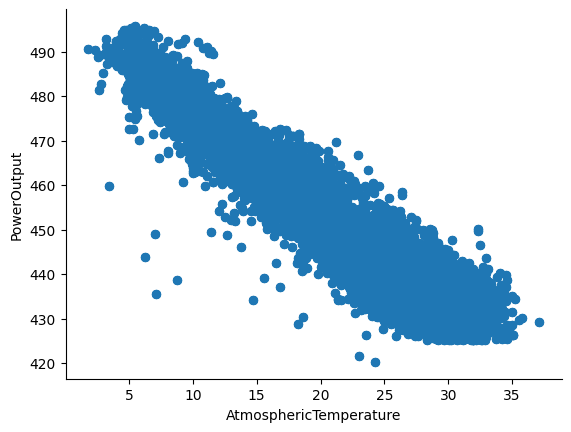

In [27]:
# @title AtmosphericTemperature vs PowerOutput

from matplotlib import pyplot as plt
tempVsPower.plot(kind='scatter', x='AtmosphericTemperature', y='PowerOutput', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

It looks like there is strong linear correlation between Temperature and Power Output.

** ASIDE: A quick physics lesson**: This correlation is to be expected as the second law of thermodynamics puts a fundamental limit on the [thermal efficiency](https://en.wikipedia.org/wiki/Thermal_efficiency) of all heat-based engines. The limiting factors are:
 - The temperature at which the heat enters the engine \\( T_{H} \\)
 - The temperature of the environment into which the engine exhausts its waste heat \\( T_C \\)

Our temperature measurements are the temperature of the environment. From [Carnot's theorem](https://en.wikipedia.org/wiki/Carnot%27s_theorem_%28thermodynamics%29), no heat engine working between these two temperatures can exceed the Carnot Cycle efficiency:
\\[ n_{th} \le 1 - \frac{T_C}{T_H}  \\]

Note that as the environmental temperature increases, the efficiency decreases -- _this is the effect that we see in the above graph._

### Exercise 4(b)

Use SQL to create a scatter plot of PowerOutput(PE) as a function of VacuumSpeed (V).
Name the y-axis "PowerOutput" and the x-axis "VacuumSpeed"

<Axes: xlabel='VacuumSpeed', ylabel='PowerOutput'>

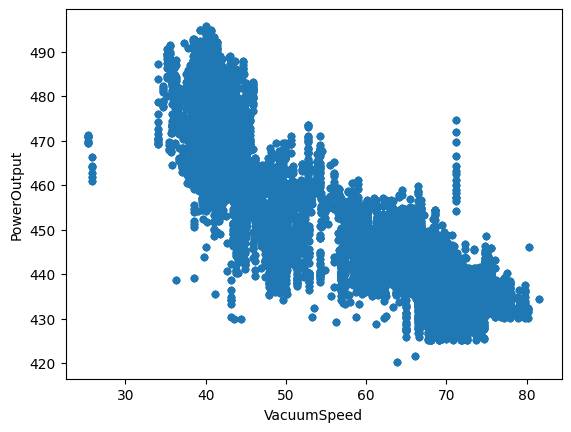

In [28]:
# TODO: Replace <FILL_IN> with the appropriate SQL command.
sqlContext.sql("select V as VacuumSpeed, PE as PowerOutput from plant_dataset").toPandas().plot.scatter(x="VacuumSpeed", y="PowerOutput")

Let's continue exploring the relationships (if any) between the variables and Power Output.

### Exercise 4(c)

Use SQL to create a scatter plot of PowerOutput(PE) as a function of AtmosphericPressure (AP).
Name the y-axis "PowerOutput" and the x-axis "AtmosphericPressure"

<Axes: xlabel='AtmosphericPressure', ylabel='PowerOutput'>

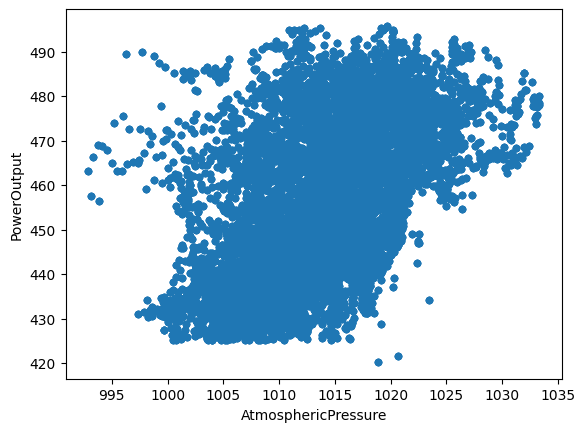

In [29]:
# TODO: Replace <FILL_IN> with the appropriate SQL command.
sqlContext.sql("select AP as AtmosphericPressure, PE as PowerOutput from plant_dataset").toPandas().plot.scatter(x="AtmosphericPressure", y="PowerOutput")

### Exercise 4(d)

Use SQL to create a scatter plot of PowerOutput(PE) as a function of RelativeHumidity(RH).
Name the y-axis "PowerOutput" and the x-axis "RelativeHumidity"

<Axes: xlabel='RelativeHumidity', ylabel='PowerOutput'>

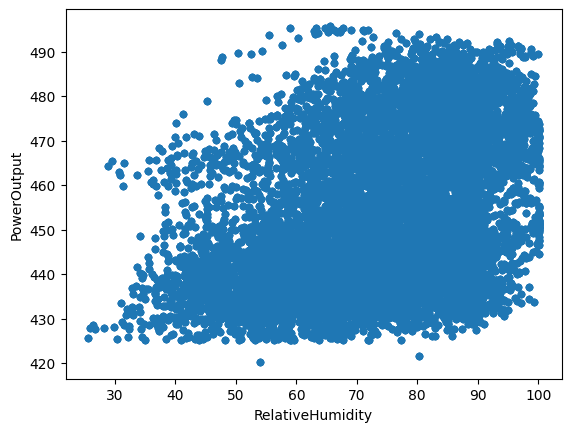

In [30]:
# TODO: Replace <FILL_IN> with the appropriate SQL command.
sqlContext.sql("select RH as RelativeHumidity, PE as PowerOutput from plant_dataset").toPandas().plot.scatter(x="RelativeHumidity", y="PowerOutput")

##Part 5: Data Preparation

The next step is to prepare the data for machine learning. Since all of this data is numeric and consistent this is a simple and straightforward task.

The goal is to use machine learning to determine a function that yields the output power as a function of a set of predictor features. The first step in building our ML pipeline is to convert the predictor features from DataFrame columns to Feature Vectors using the [pyspark.ml.feature.VectorAssembler()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler) method.

The VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees. VectorAssembler takes a list of input column names (each is a string) and the name of the output column (as a string).

### Exercise 5(a)

- Read the Spark documentation and useage examples for [VectorAssembler](https://spark.apache.org/docs/1.6.2/ml-features.html#vectorassembler).
- Convert the `plant_dataset` SQL table into a DataFrame.
- Set the vectorizer's input columns to a list of the four columns of the input DataFrame: `["AT", "V", "AP", "RH"]`.
- Set the vectorizer's output column name to `"features"`.

In [31]:
# TODO: Replace <FILL_IN> with the appropriate code
from pyspark.ml.feature import VectorAssembler

datasetDF = sqlContext.table("plant_dataset")

vectorizer = VectorAssembler()
vectorizer.setInputCols(["AT","V","AP","RH"])
vectorizer.setOutputCol("features")

VectorAssembler_4d81c69b0723

In [32]:
# TEST
Test.assertEquals(set(vectorizer.getInputCols()), {"AT", "V", "AP", "RH"}, "Incorrect vectorizer input columns")
Test.assertEquals(vectorizer.getOutputCol(), "features", "Incorrect vectorizer output column")

1 test passed.
1 test passed.


##Part 6: Data Modeling
Now let's model our data to predict what the power output will be given a set of sensor readings

Our first model will be based on simple linear regression since we saw some linear patterns in our data based on the scatter plots during the exploration stage.

We need a way of evaluating how well our linear regression model predicts power output as a function of input parameters. We can do this by splitting up our initial data set into a _Training Set_ used to train our model and a _Test Set_ used to evaluate the model's performance in giving predictions. We can use a DataFrame's [randomSplit()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) method to split our dataset. The method takes a list of weights and an optional random seed. The seed is used to initialize the random number generator used by the splitting function.

### Exercise 6(a)

Use the [randomSplit()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) method to divide up `datasetDF` into a testSetDF (15% of the input DataFrame) and a trainingSetDF (85% of the input DataFrame), and for reproducibility, use the seed 1900009193. Then cache each DataFrame in memory to maximize performance.

In [54]:
# TODO: Replace <FILL_IN> with the appropriate code.
# We'll hold out 15% of our data for testing and leave 85% for training

seed = 1900009193
(split15DF, split85DF) = datasetDF.randomSplit([0.15,0.85],seed)

# Let's cache these datasets for performance
testSetDF = split15DF.cache()
trainingSetDF = split85DF.cache()


In [55]:
# TEST
Test.assertEquals(trainingSetDF.count(), 40572, "Incorrect size for training data set")
Test.assertEquals(testSetDF.count(), 7268, "Incorrect size for test data set")

1 test failed. Incorrect size for training data set
1 test failed. Incorrect size for test data set


Next we'll create a Linear Regression Model and use the built in help to identify how to train it. See API details for [Linear Regression](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression) in the ML guide.

### Exercise 6(b)

- Read the documentation and examples for [Linear Regression](https://spark.apache.org/docs/1.6.2/ml-classification-regression.html#linear-regression)
- Run the next cell

In [48]:
# ***** LINEAR REGRESSION MODEL ****

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml import Pipeline

# Let's initialize our linear regression learner
lr = LinearRegression()

# We use explain params to dump the parameters we can use
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxBlockSizeInMB: maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0. (default: 0.0)
maxIter: max number of iterations (>= 0). (default: 100)
predic

The cell below is based on the [Spark ML Pipeline API for Linear Regression](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression).

The first step is to set the parameters for the method:
- Set the name of the prediction column to "Prediction_PE"
- Set the name of the label column to "PE"
- Set the maximum number of iterations to 100
- Set the regularization parameter to 0.15

Next, we create the [ML Pipeline](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.Pipeline) and set the stages to the Vectorizer and Linear Regression learner we created earlier.

Finally, we create a model by training on `trainingSetDF`.

### Exercise 6(c)

- Read the [Linear Regression](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression) documentation
- Run the next cell, and be sure you understand what's going on.

In [49]:
# Now we set the parameters for the method
lr.setPredictionCol("Prediction_PE")\
  .setLabelCol("PE")\
  .setMaxIter(100)\
  .setRegParam(0.15)


# We will use the new spark.ml pipeline API. If you have worked with scikit-learn this will be very familiar.
lrPipeline = Pipeline()

lrPipeline.setStages([vectorizer, lr])

# Let's first train on the entire dataset to see what we get
lrModel = lrPipeline.fit(trainingSetDF)

From the Wikipedia article on [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression):
> In statistics, linear regression is an approach for modeling the relationship between a scalar dependent variable \\( y \\) and one or more explanatory variables (or independent variables) denoted \\(X\\). In linear regression, the relationships are modeled using linear predictor functions whose unknown model parameters are estimated from the data. Such models are called linear models.

Linear regression has many practical uses. Most applications fall into one of the following two broad categories:
  - If the goal is prediction, or forecasting, or error reduction, linear regression can be used to fit a predictive model to an observed data set of \\(y\\) and \\(X\\) values. After developing such a model, if an additional value of \\(X\\) is then given without its accompanying value of \\(y\\), the fitted model can be used to make a prediction of the value of \\(y\\).
  - Given a variable \\(y\\) and a number of variables \\( X_1 \\), ..., \\( X_p \\) that may be related to \\(y\\), linear regression analysis can be applied to quantify the strength of the relationship between \\(y\\) and the \\( X_j\\), to assess which \\( X_j \\) may have no relationship with \\(y\\) at all, and to identify which subsets of the \\( X_j \\) contain redundant information about \\(y\\).

We are interested in both uses, as we would like to predict power output as a function of the input variables, and we would like to know which input variables are weakly or strongly correlated with power output.

Since Linear Regression is simply a Line of best fit over the data that minimizes the square of the error, given multiple input dimensions we can express each predictor as a line function of the form:

\\[ y = a + b x_1 + b x_2 + b x_i ... \\]

where \\(a\\) is the intercept and the \\(b\\) are the coefficients.

To express the coefficients of that line we can retrieve the Estimator stage from the PipelineModel and express the weights and the intercept for the function.

### Exercise 6(d)

Run the next cell. Ensure that you understand what's going on.

In [50]:
# The intercept is as follows:
intercept = lrModel.stages[1].intercept

# The coefficients (i.e., weights) are as follows:
weights = lrModel.stages[1].coefficients

# Create a list of the column names (without PE)
featuresNoLabel = [col for col in datasetDF.columns if col != "PE"]

# Merge the weights and labels
coefficients = list(zip(weights, featuresNoLabel))

# Now let's sort the coefficients from greatest absolute weight most to the least absolute weight
coefficients = sorted(coefficients, key=lambda tup: abs(tup[0]), reverse=True)

equation = "y = {intercept}".format(intercept=intercept)
variables = []
for x in coefficients:
    weight = abs(x[0])
    name = x[1]
    symbol = "+" if (x[0] > 0) else "-"
    equation += (" {} ({} * {})".format(symbol, weight, name))

# Finally here is our equation
print("Linear Regression Equation: " + equation)

Linear Regression Equation: y = 430.1547319365736 - (1.887206185649463 * AT) - (0.266363414350549 * V) - (0.14210654704105555 * RH) + (0.08504459065835646 * AP)


Recall **Part 4: Visualize Your Data** when we visualized each predictor against Power Output using a Scatter Plot, does the final equation seems logical given those visualizations?

### Exercise 6(e)

Now let's see what our predictions look like given this model. We apply our Linear Regression model to the 15% of the data that we split from the input dataset. The output of the model will be a predicted Power Output column named "Prediction_PE".

- Run the next cell
- Scroll through the resulting table and notice how the values in the Power Output (PE) column compare to the corresponding values in the predicted Power Output (Prediction_PE) column

In [51]:
# Apply our LR model to the test data and predict power output
resultsDF = lrModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Prediction_PE")

resultsDF.toPandas()

,AT,V,AP,RH,PE,Prediction_PE
0,2.34,39.42,1028.47,69.68,490.34,492.802450
1,2.34,39.42,1028.47,69.68,490.34,492.802450
2,2.58,39.42,1028.68,69.03,488.69,492.459749
3,2.71,39.42,1026.66,81.11,489.30,490.325975
4,3.21,38.44,1017.11,84.86,492.93,488.298332
...,...,...,...,...,...,...
5771,34.53,73.03,1013.53,36.74,437.03,426.511232
5772,34.96,68.94,1006.17,59.26,431.48,422.962992
5773,35.20,73.56,1006.56,45.72,434.37,423.236753
5774,35.77,73.56,1006.36,36.31,430.14,423.481259


From a visual inspection of the predictions, we can see that they are close to the actual values.

However, we would like a scientific measure of how well the Linear Regression model is performing in accurately predicting values. To perform this measurement, we can use an evaluation metric such as [Root Mean Squared Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE) to validate our Linear Regression model.

RSME is defined as follows: \\( RMSE = \sqrt{\frac{\sum_{i = 1}^{n} (x_i - y_i)^2}{n}}\\) where \\(y_i\\) is the observed value and \\(x_i\\) is the predicted value

RMSE is a frequently used measure of the differences between values predicted by a model or an estimator and the values actually observed. The lower the RMSE, the better our model.

Spark ML Pipeline provides several regression analysis metrics, including [RegressionEvaluator()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator).

After we create an instance of [RegressionEvaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator), we set the label column name to "PE" and set the prediction column name to "Predicted_PE". We then invoke the evaluator on the predictions.

### Exercise 6(f)

Run the next cell and ensure that you understand what's going on.

In [52]:
# Now let's compute an evaluation metric for our test dataset
from pyspark.ml.evaluation import RegressionEvaluator

# Create an RMSE evaluator using the label and predicted columns
regEval = RegressionEvaluator(predictionCol="Prediction_PE", labelCol="PE", metricName="rmse")

# Run the evaluator on the DataFrame
rmse = regEval.evaluate(resultsDF)

print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 4.52


Another useful statistical evaluation metric is the coefficient of determination, denoted \\(R^2\\) or \\(r^2\\) and pronounced "R squared". It is a number that indicates the proportion of the variance in the dependent variable that is predictable from the independent variable and it provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model. The coefficient of determination ranges from 0 to 1 (closer to 1), and the higher the value, the better our model.

To compute \\(r^2\\), we invoke the evaluator with  `regEval.metricName: "r2"`

### Exercise 6(g)

Run the next cell and ensure that you understand what's going on.

In [56]:
# Now let's compute another evaluation metric for our test dataset
r2 = regEval.evaluate(resultsDF, {regEval.metricName: "r2"})

print("r2: {0:.2f}".format(r2))

r2: 0.93


Generally, assuming a Gaussian distribution of errors, a good model will have 68% of predictions within 1 RMSE and 95% within 2 RMSE of the actual value (see http://statweb.stanford.edu/~susan/courses/s60/split/node60.html).

Let's examine the predictions and see if a RMSE of 4.60 meets this criteria.

We create a new DataFrame using [selectExpr()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.selectExpr) to project a set of SQL expressions, and register the DataFrame as a SQL table using [registerTempTable()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.registerTempTable).

### Exercise 6(h)

Run the next cell and ensure that you understand what's going on.

In [57]:
# First we remove the table if it already exists
sqlContext.sql("DROP TABLE IF EXISTS Plant_RMSE_Evaluation")

# Next we calculate the residual error and divide it by the RMSE
resultsDF.selectExpr("PE", "Prediction_PE", "PE - Prediction_PE Residual_Error", "(PE - Prediction_PE) / {} Within_RSME".format(rmse)).registerTempTable("Plant_RMSE_Evaluation")

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


We can use SQL to explore the `Plant_RMSE_Evaluation` table. First let's look at at the table using a SQL SELECT statement.

### Exercise 6(i)

Run the next cell and ensure that you understand what's going on.

In [58]:
sqlContext.sql("SELECT * from Plant_RMSE_Evaluation").toPandas()

,PE,Prediction_PE,Residual_Error,Within_RSME
0,490.34,492.802450,-2.462450,-0.544544
1,490.34,492.802450,-2.462450,-0.544544
2,488.69,492.459749,-3.769749,-0.833639
3,489.30,490.325975,-1.025975,-0.226883
4,492.93,488.298332,4.631668,1.024243
...,...,...,...,...
5771,437.03,426.511232,10.518768,2.326112
5772,431.48,422.962992,8.517008,1.883444
5773,434.37,423.236753,11.133247,2.461997
5774,430.14,423.481259,6.658741,1.472508


Now we can display the RMSE as a Histogram.

### Exercise 6(j)

Perform the following steps:

- Run the following cell
- Click on the "Bar chart" icon and view the Histogram plot


Notice that the histogram clearly shows that the RMSE is centered around 0 with the vast majority of the error within 2 RMSEs.

In [59]:
# Now we can display the RMSE as a Histogram
sqlContext.sql("SELECT Within_RSME from Plant_RMSE_Evaluation").toPandas()

,Within_RSME
0,-0.544544
1,-0.544544
2,-0.833639
3,-0.226883
4,1.024243
...,...
5771,2.326112
5772,1.883444
5773,2.461997
5774,1.472508


Using a complex SQL SELECT statement, we can count the number of predictions within + or - 1.0 and + or - 2.0 and then display the results as a pie chart.

### Exercise 6(k)

Perform the following steps:

  - Run the following cell

([<matplotlib.patches.Wedge at 0x7a70b2dd6800>,
 [Text(-0.6056442578200292, 0.9182565180654185, '1'),
  Text(-0.31959937310057507, -1.0525475004548344, '3'),
  Text(0.7026773929278511, -0.8463122836566409, '2')],
 [Text(-0.3303514133563795, 0.5008671916720464, '68.6%'),
  Text(-0.17432693078213182, -0.5741168184299096, '3.5%'),
  Text(0.383278577960646, -0.46162488199453133, '27.9%')])

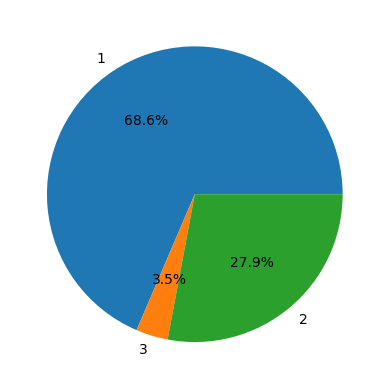

In [60]:
import matplotlib.pyplot as plt

data = sqlContext.sql("""
SELECT case
       when Within_RSME <= 1.0 AND Within_RSME >= -1.0 then 1
       when Within_RSME <= 2.0 AND Within_RSME >= -2.0 then 2
       else 3
       end RSME_Multiple, COUNT(*) AS count
FROM Plant_RMSE_Evaluation
GROUP BY RSME_Multiple
""").toPandas()


fig, ax = plt.subplots()
ax.pie(data['count'], labels=data['RSME_Multiple'], autopct='%1.1f%%')


From the pie chart, we can see that 68% of our test data predictions are within 1 RMSE of the actual values, and 97% (68% + 29%) of our test data predictions are within 2 RMSE. So the model is pretty decent. Let's see if we can tune the model to improve it further.

##Part 7: Tuning and Evaluation

Now that we have a model with all of the data let's try to make a better model by tuning over several parameters. The process of tuning a model is known as [Model Selection](https://spark.apache.org/docs/1.6.2/ml-tuning.html#model-selection-aka-hyperparameter-tuning) or [Hyperparameter Tuning](https://spark.apache.org/docs/1.6.2/ml-tuning.html#model-selection-aka-hyperparameter-tuning), and Spark ML Pipeline makes the tuning process very simple and easy.

An important task in ML is model selection, or using data to find the best model or parameters for a given task. This is also called tuning. Tuning may be done for individual Estimators such as [LinearRegression](https://spark.apache.org/docs/1.6.2/ml-classification-regression.html#linear-regression), or for entire Pipelines which include multiple algorithms, featurization, and other steps. Users can tune an entire Pipeline at once, rather than tuning each element in the Pipeline separately.

Spark ML Pipeline supports model selection using tools such as [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation), which requires the following items:
  - [Estimator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.Estimator): algorithm or Pipeline to tune
  - [Set of ParamMaps](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder): parameters to choose from, sometimes called a _parameter grid_ to search over
  - [Evaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.Evaluator): metric to measure how well a fitted Model does on held-out test data

At a high level, model selection tools such as [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) work as follows:
  - They split the input data into separate training and test datasets.
  - For each (training, test) pair, they iterate through the set of ParamMaps:
    - For each [ParamMap](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder), they fit the [Estimator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.Estimator) using those parameters, get the fitted Model, and evaluate the Model's performance using the [Evaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.Evaluator).
  - They select the Model produced by the best-performing set of parameters.

The [Evaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.Evaluator) can be a [RegressionEvaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) for regression problems. To help construct the parameter grid, users can use the [ParamGridBuilder](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) utility.

Note that cross-validation over a grid of parameters is expensive. For example, in the next cell, the parameter grid has 10 values for [lr.regParam](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression.regParam), and [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) uses 3 folds. This multiplies out to (10 x 3) = 30 different models being trained. In realistic settings, it can be common to try many more parameters (e.g., multiple values for multiple parameters) and use more folds (_k_ = 3 and _k_ = 10 are common). In other words, using [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) can be very expensive. However, it is also a well-established method for choosing parameters which is more statistically sound than heuristic hand-tuning.

We perform the following steps:
  - Create a [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) using the Pipeline and [RegressionEvaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) that we created earlier, and set the number of folds to 3
  - Create a list of 10 regularization parameters
  - Use [ParamGridBuilder](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) to build a parameter grid with the regularization parameters and add the grid to the [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation)
  - Run the [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) to find the parameters that yield the best model (i.e., lowest RMSE) and return the best model.

### Exercise 7(a)

Run the next cell. _Note that it will take some time to run the [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) as it will run almost 200 Spark jobs_

In [61]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# We can reuse the RegressionEvaluator, regEval, to judge the model based on the best Root Mean Squared Error
# Let's create our CrossValidator with 3 fold cross validation
crossval = CrossValidator(estimator=lrPipeline, evaluator=regEval, numFolds=3)

# Let's tune over our regularization parameter from 0.005 to 0.050
regParam = [x / 200.0 for x in range(1, 11)]

# We'll create a paramter grid using the ParamGridBuilder, and add the grid to the CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, regParam)
             .build())
crossval.setEstimatorParamMaps(paramGrid)

# Now let's find and return the best model
cvModel = crossval.fit(trainingSetDF).bestModel

Now that we have tuned our Linear Regression model, let's see what the new RMSE and \\(r^2\\) values are versus our intial model.

### Exercise 7(b)

Complete and run the next cell.

In [62]:
# TODO: Replace <FILL_IN> with the appropriate code.
# Now let's use cvModel to compute an evaluation metric for our test dataset: testSetDF
resultsDF = cvModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Prediction_PE")

# Run the previously created RMSE evaluator, regEval, on the resultsDF DataFrame
rmseNew = regEval.evaluate(resultsDF)

# Now let's compute the r2 evaluation metric for our test dataset
r2New = regEval.evaluate(resultsDF, {regEval.metricName: 'r2'})

print("Original Root Mean Squared Error: {0:2.2f}".format(rmse))
print("New Root Mean Squared Error: {0:2.2f}".format(rmseNew))
print("Old r2: {0:2.2f}".format(r2))
print("New r2: {0:2.2f}".format(r2New))

Original Root Mean Squared Error: 4.52
New Root Mean Squared Error: 4.51
Old r2: 0.93
New r2: 0.93


In [63]:
# TEST
Test.assertEquals(round(rmse, 2), 4.57, "Incorrect value for rmse")
Test.assertEquals(round(rmseNew, 2), 4.56, "Incorrect value for rmseNew")
Test.assertEquals(round(r2, 2), 0.93, "Incorrect value for r2")
Test.assertEquals(round(r2New, 2), 0.93, "Incorrect value for r2New")

1 test failed. Incorrect value for rmse
1 test failed. Incorrect value for rmseNew
1 test passed.
1 test passed.


So tuned linear regression model improves a little bit over our initial model. Let's look at the regularization parameter that the [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) has selected.

Recall that the orginal regularization parameter we used was 0.015.

**NOTE**: The ML Python API currently doesn't provide a way to query the regularization parameter, so we cheat, by "reaching through" to the JVM version of the API.

In [64]:
print("Regularization parameter of the best model: {0:.2f}".format(cvModel.stages[-1]._java_obj.parent().getRegParam()))

Regularization parameter of the best model: 0.01


Given that the only linearly correlated variable is Temperature, it makes sense try another Machine Learning method such as [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree_learning) to handle non-linear data and see if we can improve our model.

[Decision Tree Learning](https://en.wikipedia.org/wiki/Decision_tree_learning) uses a [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) as a predictive model which maps observations about an item to conclusions about the item's target value. It is one of the predictive modelling approaches used in statistics, data mining and machine learning. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

Spark ML Pipeline provides [DecisionTreeRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor) as an implementation of [Decision Tree Learning](https://en.wikipedia.org/wiki/Decision_tree_learning).

The cell below is based on the [Spark ML Pipeline API for Decision Tree Regressor](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor).

### Exercise 7(c)

- Read the [Decision Tree Regressor](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor) documentation
- In the next cell, create a [DecisionTreeRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor)

- The next step is to set the parameters for the method (we do this for you):
  - Set the name of the prediction column to "Prediction_PE"
  - Set the name of the label column to "PE"
  - Set the name of the features column to "features"
  - Set the maximum number of bins to 100

- Create the [ML Pipeline](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.Pipeline) and set the stages to the Vectorizer we created earlier and [DecisionTreeRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor) learner we just created.

In [84]:
# TODO: Replace <FILL_IN> with the appropriate code.
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
# Create a DecisionTreeRegressor
dt = DecisionTreeRegressor().setSeed(42)

dt.setPredictionCol("Prediction_PE").setLabelCol("PE").setFeaturesCol("features").setMaxBins(100)

# Create a Pipeline
dtPipeline = Pipeline()

# Set the stages of the Pipeline
dtPipeline.setStages([vectorizer, dt])



Pipeline_f83eca300473

In [85]:
# TEST
Test.assertEqualsHashed(str(dtPipeline.getStages()[0].__class__.__name__), '4617be70bcf475326c0b07400b97b13457cc4949', "Incorrect pipeline stage 0")
Test.assertEqualsHashed(str(dtPipeline.getStages()[1].__class__.__name__), '46b18f257cf2f778d0d3b6e30ccc7b3398d7846a', "Incorrect pipeline stage 1")

1 test passed.
1 test passed.


Instead guessing what parameters to use, we will use [Model Selection](https://spark.apache.org/docs/1.6.2/ml-tuning.html#model-selection-aka-hyperparameter-tuning) or [Hyperparameter Tuning](https://spark.apache.org/docs/1.6.2/ml-tuning.html#model-selection-aka-hyperparameter-tuning) to create the best model.

We can reuse the exiting [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) by replacing the Estimator with our new `dtPipeline` (the number of folds remains 3).

### Exercise 7(d)

- Use [ParamGridBuilder](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) to build a parameter grid with the parameter `dt.maxDepth` and a list of the values 2 and 3, and add the grid to the [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation)
- Run the [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) to find the parameters that yield the best model (i.e., lowest RMSE) and return the best model.

_Note that it will take some time to run the [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) as it will run almost 50 Spark jobs_

In [86]:
# TODO: Replace <FILL_IN> with the appropriate code.
# Let's just reuse our CrossValidator with the new dtPipeline, RegressionEvaluator regEval, and 3 fold cross validation
crossval.setEstimator(dtPipeline)

# Let's tune over our dt.maxDepth parameter on the values 2 and 3, create a paramter grid using the ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 3])
             .build())

# Add the grid to the CrossValidator
crossval.setEstimatorParamMaps(paramGrid)

# Now let's find and return the best model
dtModel = crossval.fit(trainingSetDF).bestModel



In [87]:
# TEST
Test.assertEqualsHashed(str(dtModel.stages[0].__class__.__name__), '4617be70bcf475326c0b07400b97b13457cc4949', "Incorrect pipeline stage 0")
Test.assertEqualsHashed(str(dtModel.stages[1].__class__.__name__), 'a2bf7b0c1a0fb9ad35650d0478ad51a9b880befa', "Incorrect pipeline stage 1")

1 test passed.
1 test passed.


### Exercise 7(e)

Now let's see how our tuned DecisionTreeRegressor model's RMSE and \\(r^2\\) values compare to our tuned LinearRegression model.

Complete and run the next cell.

In [88]:
# TODO: Replace <FILL_IN> with the appropriate code.

# Now let's use dtModel to compute an evaluation metric for our test dataset: testSetDF
resultsDF = dtModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Prediction_PE")

# Run the previously created RMSE evaluator, regEval, on the resultsDF DataFrame
rmseDT = regEval.evaluate(resultsDF)

# Now let's compute the r2 evaluation metric for our test dataset
r2DT = regEval.evaluate(resultsDF, {regEval.metricName: 'r2'})

print("LR Root Mean Squared Error: {0:.2f}".format(rmseNew))
print("DT Root Mean Squared Error: {0:.2f}".format(rmseDT))
print("LR r2: {0:.2f}".format(r2New))
print("DT r2: {0:.2f}".format(r2DT))

LR Root Mean Squared Error: 4.51
DT Root Mean Squared Error: 5.04
LR r2: 0.93
DT r2: 0.91


In [89]:
# TEST
Test.assertEquals(round(rmseDT, 2), 5.12, "Incorrect value for rmseDT")
Test.assertEquals(round(r2DT, 2), 0.91, "Incorrect value for r2DT")

1 test failed. Incorrect value for rmseDT
1 test passed.


The line below will pull the Decision Tree model from the Pipeline as display it as an if-then-else string. Again, we have to "reach through" to the JVM API to make this one work.

**TODO**: Run the next cell

In [90]:
print(dtModel.stages[-1]._java_obj.toDebugString())

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_b6c6a57c8903, depth=3, numNodes=15, numFeatures=4
  If (feature 0 <= 17.884999999999998)
   If (feature 0 <= 11.805)
    If (feature 0 <= 8.605)
     Predict: 483.8979148770011
    Else (feature 0 > 8.605)
     Predict: 476.0183716255027
   Else (feature 0 > 11.805)
    If (feature 0 <= 14.485)
     Predict: 468.72428848283494
    Else (feature 0 > 14.485)
     Predict: 461.94741324079024
  Else (feature 0 > 17.884999999999998)
   If (feature 0 <= 22.619999999999997)
    If (feature 1 <= 47.335)
     Predict: 457.65481168332064
    Else (feature 1 > 47.335)
     Predict: 449.25268710550034
   Else (feature 0 > 22.619999999999997)
    If (feature 1 <= 66.11)
     Predict: 443.0551429592566
    Else (feature 1 > 66.11)
     Predict: 434.83292321566597



So our DecisionTree has slightly worse RMSE than our LinearRegression model (LR: 4.55 vs DT: 5.07). Maybe we can try an [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning) method such as [Gradient-Boosted Decision Trees](https://en.wikipedia.org/wiki/Gradient_boosting) to see if we can strengthen our model by using an ensemble of weaker trees with weighting to reduce the error in our model.

[Random forests](https://en.wikipedia.org/wiki/Random_forest) or random decision tree forests are an ensemble learning method for regression that operate by constructing a multitude of decision trees at training time and outputting the class that is the mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

Spark ML Pipeline provides [RandomForestRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor) as an implementation of [Random forests](https://en.wikipedia.org/wiki/Random_forest).

The cell below is based on the [Spark ML Pipeline API for Random Forest Regressor](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor).

### Exercise 7(f)

- Read the [Random Forest Regressor](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor) documentation
- In the next cell, create a [RandomForestRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor)
- The next step is to set the parameters for the method (we do this for you):
  - Set the name of the prediction column to "Prediction_PE"
  - Set the name of the label column to "PE"
  - Set the name of the features column to "features"
  - Set the random number generator seed to 190088121
  - Set the maximum depth to 8
  - Set the number of trees to 25
- Create the [ML Pipeline](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.Pipeline) and set the stages to the Vectorizer we created earlier and [RandomForestRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor) learner we just created.

In [91]:
# TODO: Replace <FILL_IN> with the appropriate code.

from pyspark.ml.regression import RandomForestRegressor

# Create a RandomForestRegressor
rf = RandomForestRegressor()

rf.setPredictionCol("Prediction_PE").setFeaturesCol("features").setSeed(190088121).setMaxDepth(8).setNumTrees(25).setLabelCol("PE")

# Create a Pipeline
rfPipeline = Pipeline()

# Set the stages of the Pipeline
rfPipeline.setStages([vectorizer, rf])


Pipeline_afe1689f35d3

In [92]:
# TEST
Test.assertEqualsHashed(rfPipeline.getStages()[0].__class__.__name__, '4617be70bcf475326c0b07400b97b13457cc4949', "Stage 0 of pipeline is not correct")
Test.assertEqualsHashed(rfPipeline.getStages()[1].__class__.__name__, 'ecdcce2d075f00c97a6d2a2b8b1f66de322e57d2', "Stage 1 of pipeline is not correct")

1 test passed.
1 test passed.


As with Decision Trees, instead guessing what parameters to use, we will use [Model Selection](https://spark.apache.org/docs/1.6.2/ml-tuning.html#model-selection-aka-hyperparameter-tuning) or [Hyperparameter Tuning](https://spark.apache.org/docs/1.6.2/ml-tuning.html#model-selection-aka-hyperparameter-tuning) to create the best model.

We can reuse the exiting [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) by replacing the Estimator with our new `rfPipeline` (the number of folds remains 3).

### Exercise 7(g)

- Use [ParamGridBuilder](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) to build a parameter grid with the parameter `rf.maxBins` and a list of the values 50 and 100, and add the grid to the [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation)
- Run the [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) to find the parameters that yield the best model (i.e., lowest RMSE) and return the best model.

_Note that it will take some time to run the [CrossValidator](https://spark.apache.org/docs/1.6.2/ml-tuning.html#cross-validation) as it will run almost 100 Spark jobs, and each job takes longer to run than the prior CrossValidator runs._

In [95]:
# TODO: Replace <FILL_IN> with the appropriate code.
# Let's just reuse our CrossValidator with the new rfPipeline,  RegressionEvaluator regEval, and 3 fold cross validation
crossval.setEstimator(rfPipeline).setEvaluator(regEval).setNumFolds(3)

# Let's tune over our rf.maxBins parameter on the values 50 and 100, create a paramter grid using the ParamGridBuilder
paramGrid = ParamGridBuilder().addGrid(rf.maxBins, [50,100]).build()

# Add the grid to the CrossValidator
crossval.setEstimatorParamMaps(paramGrid)

# Now let's find and return the best model
rfModel = crossval.fit(trainingSetDF).bestModel

In [96]:
# TEST
Test.assertEqualsHashed(rfModel.stages[0].__class__, 'f0c3b910468d87808e019409e7ae5e587d6aca3d', 'rfModel has incorrect stage 0')
Test.assertEqualsHashed(rfModel.stages[1].__class__, '0ed43512ea7e35ebeebeed3ddac0186248999a87', 'rfModel has incorrect stage 1')

1 test passed.
1 test passed.


### Exercise 7(h)

Now let's see how our tuned RandomForestRegressor model's RMSE and \\(r^2\\) values compare to our tuned LinearRegression and tuned DecisionTreeRegressor models.

** TODO**: Complete and run the next cell.

In [97]:
# TODO: Replace <FILL_IN> with the appropriate code.

# Now let's use rfModel to compute an evaluation metric for our test dataset: testSetDF
resultsDF = rfModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Prediction_PE")


# Run the previously created RMSE evaluator, regEval, on the resultsDF DataFrame
rmseRF = regEval.evaluate(resultsDF)

# Now let's compute the r2 evaluation metric for our test dataset
r2RF = regEval.evaluate(resultsDF, {regEval.metricName: 'r2'})

print("LR Root Mean Squared Error: {0:.2f}".format(rmseNew))
print("DT Root Mean Squared Error: {0:.2f}".format(rmseDT))
print("RF Root Mean Squared Error: {0:.2f}".format(rmseRF))
print("LR r2: {0:.2f}".format(r2New))
print("DT r2: {0:.2f}".format(r2DT))
print("RF r2: {0:.2f}".format(r2RF))

LR Root Mean Squared Error: 4.51
DT Root Mean Squared Error: 5.04
RF Root Mean Squared Error: 3.44
LR r2: 0.93
DT r2: 0.91
RF r2: 0.96


In [98]:
# TEST
Test.assertEquals(round(rmseRF, 2), 3.45, "Incorrect value for rmseRF")
Test.assertEquals(round(r2RF, 2), 0.96, "Incorrect value for r2RF")

1 test failed. Incorrect value for rmseRF
1 test passed.


Note that the RMSE for the Random Forest model is better.

The line below will pull the Random Forest model from the Pipeline as display it as an if-then-else string.

**ToDo**: Run the next cell

In [99]:
print(rfModel.stages[-1]._java_obj.toDebugString())

RandomForestRegressionModel: uid=RandomForestRegressor_c0d040510ef1, numTrees=25, numFeatures=4
  Tree 0 (weight 1.0):
    If (feature 0 <= 17.695)
     If (feature 2 <= 1018.535)
      If (feature 1 <= 44.615)
       If (feature 1 <= 40.445)
        If (feature 3 <= 84.06)
         If (feature 0 <= 10.325)
          If (feature 0 <= 8.635000000000002)
           If (feature 0 <= 7.425000000000001)
            Predict: 486.9269130434783
           Else (feature 0 > 7.425000000000001)
            Predict: 482.5862913907285
          Else (feature 0 > 8.635000000000002)
           If (feature 1 <= 36.685)
            Predict: 474.28096774193546
           Else (feature 1 > 36.685)
            Predict: 477.94924623115577
         Else (feature 0 > 10.325)
          If (feature 1 <= 40.21)
           If (feature 0 <= 13.605)
            Predict: 472.9565316455697
           Else (feature 0 > 13.605)
            Predict: 465.7987818696883
          Else (feature 1 > 40.21)
           If (fe

### Conclusion

Wow! So our best model is in fact our Decision tree model outperforms the random forrest ensemble model.